In [1]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from glob import glob
from skimage import img_as_float32
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import json
import sklearn
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from skimage import img_as_float32
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Dense, Softmax
from tensorflow.keras import layers
from skimage.util import random_noise


In [2]:
def split(imgs, msks):

    c = list(zip(imgs, msks))
    random.shuffle(c)
    imgs, msks = zip(*c)

    train = 34
    val = 7
    test = 7

    x_train, y_train = imgs[:train], msks[:train]
    x_val, y_val = imgs[train:train+val], msks[train:train+val]
    x_test, y_test = imgs[-1*test:], msks[-1*test:]

    return x_train, y_train, x_val, y_val, x_test, y_test

path_pairs = list(zip(
natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([cv2.resize(img_as_float32(imageio.imread(ipath)), (192, 256)) for ipath, _ in path_pairs])
msks = np.array([cv2.resize(img_as_float32(imageio.imread(mpath)), (192, 256)) for _, mpath in path_pairs])

x_train, y_train, x_val, y_val, x_test, y_test = split(imgs, msks)

In [6]:
vgg16_pretrained = VGG16(include_top=False, weights='imagenet', input_shape=(256, 192, 3))

In [7]:
def augment_data(x, y, k = (3, 3), sx = 1, size=(192, 256)):

    def brightness(img, scale):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv[:, :, 2] = hsv[:, :, 2] * scale

        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    def sat(img, scale):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv[:, :, 1] = hsv[:, :, 1] * scale

        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    images = list(x)
    masks = list(y)

    

    # for i in range(len(x)):
    #     # Flip
    #     images.append(cv2.flip(x[i], 0))
    #     images.append(cv2.flip(x[i], 1))
    #     masks.append(cv2.flip(y[i], 0))
    #     masks.append(cv2.flip(y[i], 1))
    
    #     # Rotations
    #     images.append(cv2.rotate(x[i], cv2.ROTATE_90_CLOCKWISE))
    #     images.append(cv2.rotate(x[i], cv2.ROTATE_90_COUNTERCLOCKWISE))
    #     masks.append(cv2.rotate(y[i], cv2.ROTATE_90_CLOCKWISE))
    #     masks.append(cv2.rotate(y[i], cv2.ROTATE_90_COUNTERCLOCKWISE))

    #     images.append(cv2.rotate(x[i], cv2.ROTATE_180))
    #     masks.append(cv2.rotate(y[i], cv2.ROTATE_180))

    #     # Brightness and saturation

    #     images.append(brightness(x[i], 1.2))
    #     images.append(brightness(x[i], 0.8))
    #     masks.append(y[i])
    #     masks.append(y[i])

    #     images.append(sat(x[i], 3))
    #     images.append(sat(x[i], 0.5))
    #     masks.append(y[i])
    #     masks.append(y[i])


    

    # for i in range(len(images)):
    #     # Blur and Noise
    #     images.append(cv2.GaussianBlur(images[i], k, sx))
    #     images.append(random_noise(images[i], mode='s&p'))
    #     masks.append(masks[i])
    #     masks.append(masks[i])

        
    # for i in range(len(masks)):
    #     images[i] = cv2.resize(images[i], size)
    #     masks[i] = cv2.resize(masks[i], size)



    return np.array(images), np.array(masks)

def get_data(x_train, y_train, x_val, y_val, x_test, y_test):
    x_train, y_train = augment_data(x_train, y_train)
    x_val = np.array(list(x_val))
    y_val = np.array(list(y_val))
    x_test = np.array(list(x_val))
    y_test = np.array(list(y_val))

    

    data_train = tf.data.Dataset.from_tensor_slices((

            {
                'x' : np.expand_dims(x_train, axis=0)
            },
            {
                'y' : tf.one_hot(np.expand_dims(y_train, axis=0), depth=2, dtype=tf.int32)
            }
        )
    )

    data_val = tf.data.Dataset.from_tensor_slices((

            {
                'x' : np.expand_dims(x_val, axis=0)
            },
            {
                'y' : tf.one_hot(np.expand_dims(y_val, axis=0), depth=2, dtype=tf.int32)
            }
        )
    )

    data_test = tf.data.Dataset.from_tensor_slices((

            {
                'x' : np.expand_dims(x_test, axis=0)
            },
            {
                'y' : tf.one_hot(np.expand_dims(y_test, axis=0), depth=2, dtype=tf.int32)
            }
        )
    )
    return data_train, data_val, data_test

train, val, test = get_data(x_train, y_train, x_val, y_val, x_test, y_test)


In [8]:
class UnetVGG():
    def __init__(self, input: tuple, num_classes: int, lr: float):
        self.input_shape = input
        self.num_classes = num_classes
        self.learning_rate = lr

        self.optimizer = Nadam(learning_rate=lr)
        self.model = self.build_model(self.input_shape, self.num_classes)

        self.model.compile(optimizer = self.optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

    def build_model(self, input_shape, num_classes):
        encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
        encoder.layers[0]._name  = 'x'

        encoder_output = encoder.output
        conv0 = Conv2D(512, 3, activation='relu', padding='same')(encoder_output)
        conv0_trans = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv0)

        concat1 = concatenate([encoder.get_layer('block5_conv3').output, conv0_trans])
        conv1 = Conv2D(512, 3, activation='relu', padding='same')(concat1)
        conv1_trans = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv1)

        concat2 = concatenate([encoder.get_layer('block4_conv3').output, conv1_trans])
        conv2 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat2)
        conv2_trans = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(conv2)

        concat3 = concatenate([encoder.get_layer('block3_conv3').output, conv2_trans])
        conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat3)
        conv3_trans = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(conv3)

        concat_4 = concatenate([encoder.get_layer('block2_conv2').output, conv3_trans])
        conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_4)
        conv4_trans = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(conv4)

        concat5 = concatenate([encoder.get_layer('block1_conv2').output, conv4_trans])
        conv5 = Conv2D(32, 3, activation='relu', padding='same')(concat5)

        out = Conv2D(num_classes, 1, activation='softmax', name='y')(conv5)

        return Model(inputs = encoder.layers[0].input, outputs=out, name="UnetVGG")

    def train(self, train, val, epochs):
        self.model.fit(train, validation_data = val, epochs=epochs)

    def predict(self, data):
        return np.squeeze(self.model.predict(data))

    def summary(self):
        self.model.summary()


In [9]:
model = UnetVGG((256, 192, 3), 2, 1e-3)
model.train(train, val, 5)

Epoch 1/5
1/1 [==============================] - 48s 48s/step - loss: 0.9975 - accuracy: 0.7537 - val_loss: 3.9953 - val_accuracy: 0.2677
Epoch 2/5
1/1 [==============================] - 41s 41s/step - loss: 4.1168 - accuracy: 0.2504 - val_loss: 0.5816 - val_accuracy: 0.7416
Epoch 3/5
1/1 [==============================] - 38s 38s/step - loss: 0.5720 - accuracy: 0.7573 - val_loss: 0.4881 - val_accuracy: 0.7520
Epoch 4/5
1/1 [==============================] - 41s 41s/step - loss: 0.4914 - accuracy: 0.7646 - val_loss: 0.4441 - val_accuracy: 0.7687
Epoch 5/5
1/1 [==============================] - 41s 41s/step - loss: 0.4540 - accuracy: 0.7770 - val_loss: 0.4272 - val_accuracy: 0.8550


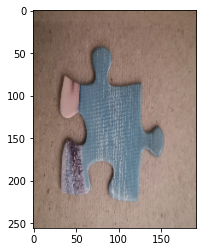

In [12]:
plt.imshow(x_train[0])

In [22]:
temp = x_train[0]
temp = np.expand_dims(temp, axis=0)
temp.shape

(1, 256, 192, 3)

In [24]:
result = model.predict(temp)

1/1 [==============================] - 1s 508ms/step


In [26]:
result_new = np.argmax(result,axis=-1).astype(np.float32)

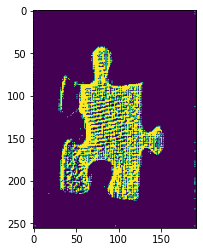

In [28]:
plt.imshow(result_new)

In [25]:
def post_processing(fg_bg_pred, kernel_dims):
    """Apply morhpolical transformations of closing
    and opening"""
    kernel = np.ones((kernel_dims, kernel_dims),np.uint8)
    fg_bg_pred = cv2.morphologyEx(fg_bg_pred, cv2.MORPH_OPEN, kernel)
    fg_bg_pred = cv2.morphologyEx(fg_bg_pred, cv2.MORPH_CLOSE, kernel)
    return fg_bg_pred

(34, 256, 192)


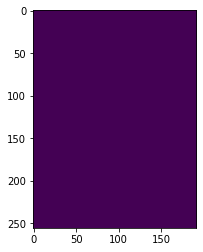

In [32]:
fg_bg_pred = result[:,:, :, 0:2]
fg_bg_pred = np.argmax(fg_bg_pred, axis=-1).astype(np.float32)
fg_bg_pred = post_processing(fg_bg_pred,5)
print(fg_bg_pred.shape)
plt.imshow(fg_bg_pred[0,:,:])

In [33]:
def show_image(image,cs=False,cmap= None, title=None):
	# if cs:
	#     norm_img = normalise_data(image)
	# else:
	norm_img = image
	plt.title(title)
	plt.imshow(norm_img, cmap= cmap)
	plt.xticks([])
	plt.yticks([])

In [34]:
def test_predictions(num_classes, vgg_unet, test_images, test_masks, morph_dims, plot=True):
    predict_count = 0
    total_score = 0
    for image, mask in zip(test_images, test_masks) :
        predict_count += 1
        pred = vgg_unet.predict(image)
        fg_bg_pred = pred[:, :, 0:2]
        fg_bg_pred = np.argmax(fg_bg_pred, axis=-1).astype(np.float32)
        fg_bg_pred = post_processing(fg_bg_pred, morph_dims)
        # score = accuracy_score(fg_bg_pred.flatten(), mask.flatten().round())
        if num_classes == 3:
            corner_pred = pred[:, :, 2]
            # final_image = set_corner_segmentation(fg_bg_pred, corner_pred)
        else:
            final_image = fg_bg_pred
        # print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        # total_score += score
        if plot:
            show_image(final_image)
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )  

In [ ]:
# test_predictions(2,model,val)